<a href="https://colab.research.google.com/github/randyRivera0/LandUseAndWildlifeDLSemanticSegmentation/blob/main/LandUseAndWildlifeDLSemanticSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Cidis LandUseAndWildlifeDLSemanticSegmentation project for Galapagos and ESPOL university](https://www.cidis.espol.edu.ec/sites/default/files/default_images/logo_defecto.png)](https://www.cidis.espol.edu.ec/)
# Train YOLO11 Object Detection on a Custom Galapagos Marine Iguana Dataset
---
[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/randyRivera0/LandUseAndWildlifeDLSemanticSegmentation)


[![Roboflow](https://img.shields.io/badge/Roboflow-Dataset-orange)](https://app.roboflow.com/geckos-land/)



Professor: Phd. Miguel Andrés Realpe Robalino

## Weekly Objectives:

### Tasks
- [ ] Join train, val and test graphics (also scale them)
- [ ] Use best and last pt
- [ ] Test img: separate the labels, boxes and Semantic Segmentation
- [ ] Create new metrics with logs
- [ ] Discover which metrics is using the system to stop the iterations and use the good ones
- [ ] Organize and join collab with github also using a remote running server
- [ ] Lean anout the hauid
- [ ] Use SAM for land segmentation
- [ ] Add more img to val
- [ ] Use jupyter to track progress
- [ ] Show multiple real and predict
- [ ] Small Object Detection
- [ ] Continue with the pretrain
- [ ] Wandb or TensorBoard

### Questions
- Torch out of memory solved removing flag amp=False

### Next Steps
- Integrate Use of Land and develop functionality for biologists


## Setup

In [1]:
!nvidia-smi

Fri Nov 22 11:03:51 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
# %conda env export > environment.yml

In [3]:
pip install Roboflow ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.4/887.4 kB 30.6 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10


In [4]:
import __main__
import sys
import os
from pathlib import Path
import torch
import torchvision
from roboflow import Roboflow
from IPython.display import Image as IPyImage, display
import ultralytics
from ultralytics import YOLO
import glob
import pandas as pd
import matplotlib.pyplot as plt

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [5]:
# Determine runtime

def in_colab():
    from IPython.core import getipython
    return 'google.colab' in str(getipython.get_ipython())

def is_colab2():
    try:
        import google.colab
        return True
    except ImportError:
        return False

def get_runtime():
    if "google.colab" in sys.modules:
        return "Google Colab"
    elif "ipykernel" in sys.modules:
        if "jupyter" in sys.modules:
            return "JupyterLab"
        else:
            return "Jupyter Notebook"
    elif "win32" in sys.platform:
        if 'CMDEXTVERSION' in os.environ:
            return "Windows Command Prompt"
        else:
            return "Windows PowerShell"
    elif "darwin" in sys.platform:
        return "MacOS Terminal"
    else:
        if hasattr(__main__,'__file__'):
            return "Linux Terminal"
        else:
            return "Interactive Python Shell"

print(get_runtime())

Google Colab


In [6]:
if in_colab:
  from google.colab import userdata

In [7]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # Restrict visibility to the TITAN V only


In [8]:
# Check if CUDA (GPU) is available
if torch.cuda.is_available():
    print("CUDA disponible:")
    print("Versión de CUDA:", torch.version.cuda)
    gpu_name = torch.cuda.get_device_name(0)
    print("Current device:", torch.cuda.current_device())  # Should output '0'
    print("Device name:", torch.cuda.get_device_name(0))   # Should output 'NVIDIA TITAN V'
else:
    print("No GPU available")

CUDA disponible:
Versión de CUDA: 12.1
Current device: 0
Device name: Tesla T4


In [9]:
torch.__version__

'2.5.1+cu121'

In [10]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


In [11]:
### NMS Test
print(torch.__version__)
print(torchvision.__version__)
device = 'cuda'
boxes = torch.tensor([[0., 1., 2., 3.]]).to(device)
scores = torch.randn(1).to(device)
iou_threshold = 0.5

print(torchvision.ops.nms(boxes, scores, iou_threshold))


2.5.1+cu121
0.20.1+cu121
tensor([0], device='cuda:0')


In [12]:
ultralytics.checks()
HOME = Path.cwd()

Ultralytics 8.3.35 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 32.5/112.6 GB disk)


In [13]:
# Initialize Roboflow with your API key
if in_colab():
    ROBOFLOW_API_KEY = userdata.get('ROBOFLOW_API_KEY')
    rf = Roboflow(api_key=ROBOFLOW_API_KEY)
else:
    rf = Roboflow(api_key="oO7M6O03cXw3x36PVBxq") # Replace with your actual API key

In [14]:
datasets_dir = HOME / 'datasets'

# Create the datasets directory (if it doesn't already exist)
datasets_dir.mkdir(parents=True, exist_ok=True)

os.chdir(datasets_dir)

# Print the current working directory
print(f"Current directory: {os.getcwd()}")

Current directory: /content/datasets


## Iguanas

In [15]:
os.chdir(datasets_dir)

project = rf.workspace("geckos-land").project("galapagosiguanas")
version = project.version(1)
dataset = version.download("yolov11")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to GalapagosIguanas-1 in yolov11:: 100%|██████████| 130/130 [00:00<00:00, 2958.67it/s]


In [ ]:
# Trial
os.chdir(HOME)

!yolo task=detect mode=train model=yolo11l-seg.pt data={dataset.location}/data.yaml epochs=3 imgsz=640 plots=True

100% 53.5M/53.5M [00:00<00:00, 318MB/s]
WARNING ⚠️ conflicting 'task=detect' passed with 'task=segment' model. Ignoring 'task=detect' and updating to 'task=segment' to match model.
Ultralytics 8.3.35 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=segment, mode=train, model=yolo11l-seg.pt, data=/content/datasets/GalapagosIguanas-1/data.yaml, epochs=3, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, a

In [19]:
os.chdir(HOME)

!yolo task=detect mode=train model=yolo11l-seg.pt data={dataset.location}/data.yaml epochs=300 imgsz=640 plots=True patience=0

Traceback (most recent call last):
  File "/usr/local/bin/yolo", line 5, in <module>
    from ultralytics.cfg import entrypoint
  File "/usr/local/lib/python3.10/dist-packages/ultralytics/__init__.py", line 11, in <module>
    from ultralytics.models import NAS, RTDETR, SAM, YOLO, FastSAM, YOLOWorld
  File "/usr/local/lib/python3.10/dist-packages/ultralytics/models/__init__.py", line 3, in <module>
    from .fastsam import FastSAM
  File "/usr/local/lib/python3.10/dist-packages/ultralytics/models/fastsam/__init__.py", line 3, in <module>
    from .model import FastSAM
  File "/usr/local/lib/python3.10/dist-packages/ultralytics/models/fastsam/model.py", line 5, in <module>
    from ultralytics.engine.model import Model
  File "/usr/local/lib/python3.10/dist-packages/ultralytics/engine/model.py", line 11, in <module>
    from ultralytics.cfg import TASK2DATA, get_cfg, get_save_dir
  File "/usr/local/lib/python3.10/dist-packages/ultralytics/cfg/__init__.py", line 12, in <module>
    from 

In [ ]:
os.chdir(HOME)

!yolo task=detect mode=train model=yolo11l-seg.pt data={dataset.location}/data.yaml epochs=200 imgsz=640 plots=True amp=False

WARNING ⚠️ conflicting 'task=detect' passed with 'task=segment' model. Ignoring 'task=detect' and updating to 'task=segment' to match model.
Ultralytics 8.3.34 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=segment, mode=train, model=yolo11l-seg.pt, data=/content/datasets/GalapagosIguanas-1/data.yaml, epochs=200, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train4, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=False, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, cl

In [ ]:
# PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True

import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
import torch
# Your code here


### Best model


In [ ]:
!yolo task=detect mode=val model={HOME}/runs/segment/train/weights/best.pt data={dataset.location}/data.yaml

Traceback (most recent call last):
  File "/usr/local/bin/yolo", line 8, in <module>
    sys.exit(entrypoint())
  File "/usr/local/lib/python3.10/dist-packages/ultralytics/cfg/__init__.py", line 940, in entrypoint
    model = YOLO(model, task=task)
  File "/usr/local/lib/python3.10/dist-packages/ultralytics/models/yolo/model.py", line 23, in __init__
    super().__init__(model=model, task=task, verbose=verbose)
  File "/usr/local/lib/python3.10/dist-packages/ultralytics/engine/model.py", line 145, in __init__
    self._load(model, task=task)
  File "/usr/local/lib/python3.10/dist-packages/ultralytics/engine/model.py", line 285, in _load
    self.model, self.ckpt = attempt_load_one_weight(weights)
  File "/usr/local/lib/python3.10/dist-packages/ultralytics/nn/tasks.py", line 910, in attempt_load_one_weight
    ckpt, weight = torch_safe_load(weight)  # load ckpt
  File "/usr/local/lib/python3.10/dist-packages/ultralytics/nn/tasks.py", line 837, in torch_safe_load
    ckpt = torch.load(fi

In [ ]:
!yolo task=detect mode=predict model={HOME}/runs/segment/train/weights/best.pt conf=0.25 source={dataset.location}/test/images save=True

Traceback (most recent call last):
  File "/usr/local/bin/yolo", line 8, in <module>
    sys.exit(entrypoint())
  File "/usr/local/lib/python3.10/dist-packages/ultralytics/cfg/__init__.py", line 940, in entrypoint
    model = YOLO(model, task=task)
  File "/usr/local/lib/python3.10/dist-packages/ultralytics/models/yolo/model.py", line 23, in __init__
    super().__init__(model=model, task=task, verbose=verbose)
  File "/usr/local/lib/python3.10/dist-packages/ultralytics/engine/model.py", line 145, in __init__
    self._load(model, task=task)
  File "/usr/local/lib/python3.10/dist-packages/ultralytics/engine/model.py", line 285, in _load
    self.model, self.ckpt = attempt_load_one_weight(weights)
  File "/usr/local/lib/python3.10/dist-packages/ultralytics/nn/tasks.py", line 910, in attempt_load_one_weight
    ckpt, weight = torch_safe_load(weight)  # load ckpt
  File "/usr/local/lib/python3.10/dist-packages/ultralytics/nn/tasks.py", line 837, in torch_safe_load
    ckpt = torch.load(fi

In [ ]:
IPyImage(filename=f'{HOME}\\runs\\segment\\train2\confusion_matrix.png', width=600)

FileNotFoundError: [Errno 2] No such file or directory: '/content\\runs\\segment\\train2\\confusion_matrix.png'

In [ ]:
IPyImage(filename=f'{HOME}/runs/segment/train5/results.png', width=600)

In [ ]:
IPyImage(filename=f'{HOME}/runs/segment/train2/val_batch0_pred.jpg', width=600)

In [ ]:
import glob
import os
from IPython.display import Image as IPyImage, display

latest_folder = max(glob.glob(f'{HOME}/runs/segment/predict2*/'), key=os.path.getmtime)
for img in glob.glob(f'{latest_folder}/*.jpg')[:3]:
    display(IPyImage(filename=img, width=600))
    print("\n")

### Last model

In [ ]:
!yolo task=detect mode=val model={HOME}/runs/segment/train/weights/best.pt data={dataset.location}/data.yaml

### Visualization

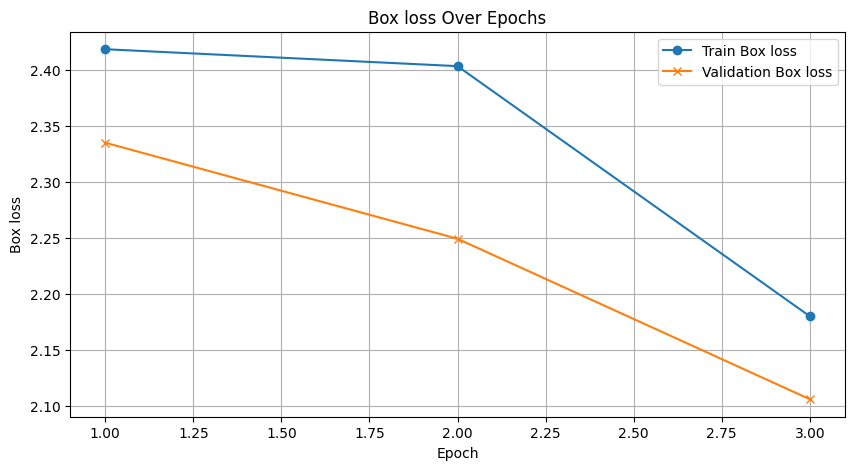

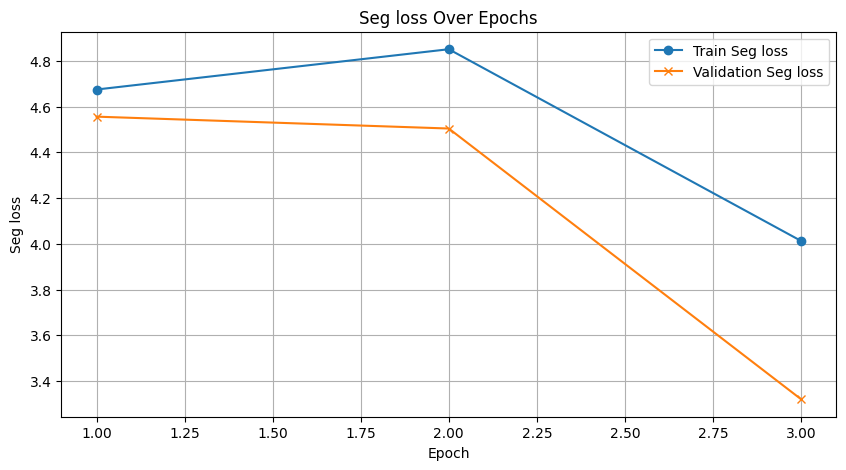

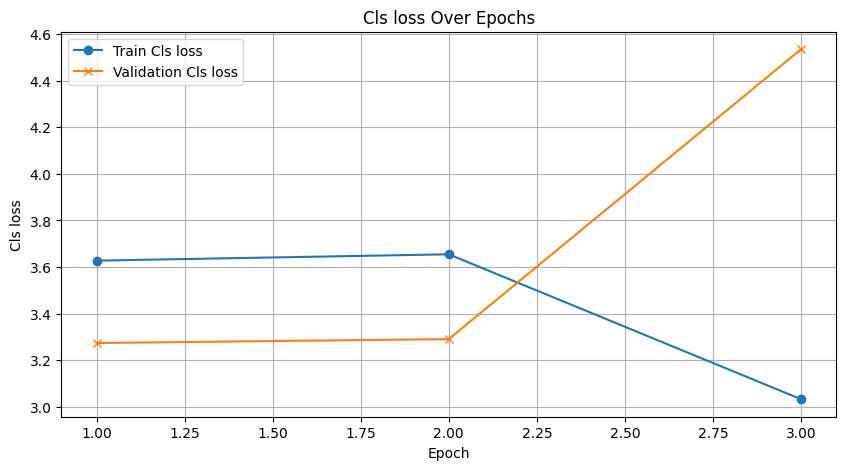

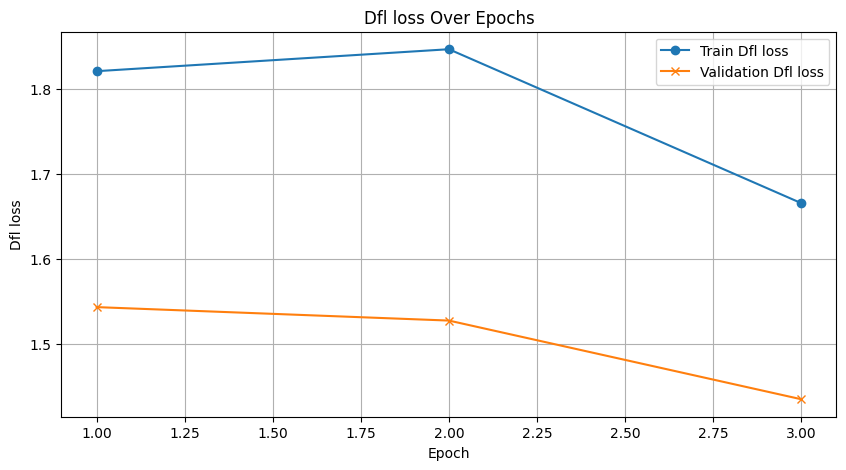

In [ ]:
# Convert to DataFrame
df = pd.read_csv("/content/runs/segment/train/results.csv")

# Identify columns for plotting
train_columns = [col for col in df.columns if col.startswith("train/")]
val_columns = [col for col in df.columns if col.startswith("val/")]

# Automate plotting for matching train/val columns
for train_col in train_columns:
    # Find corresponding validation column
    val_col = train_col.replace("train/", "val/")
    if val_col in val_columns:
        # Extract metric name
        metric_name = train_col.split("/")[-1].replace("_", " ").capitalize()

        # Plot
        plt.figure(figsize=(10, 5))
        plt.plot(df['epoch'], df[train_col], label=f'Train {metric_name}', marker='o')
        plt.plot(df['epoch'], df[val_col], label=f'Validation {metric_name}', marker='x')
        plt.xlabel('Epoch')
        plt.ylabel(metric_name)
        plt.title(f'{metric_name} Over Epochs')
        plt.legend()
        plt.grid(True)
        plt.show()


## Land Use


In [ ]:
os.chdir(datasets_dir)

project = rf.workspace("geckos-land").project("drone-6vm9j")
version = project.version(1)
dataset = version.download("yolov11")

In [ ]:
os.chdir(HOME)

!yolo task=detect mode=train model=yolo11s-seg.pt data={dataset.location}/data.yaml epochs=10 imgsz=6

In [ ]:
IPyImage(filename=f'{HOME}/runs/segment/train3/confusion_matrix.png', width=600)


In [ ]:
IPyImage(filename=f'{HOME}/runs/segment/train3/results.png', width=600)

In [ ]:
IPyImage(filename=f'{HOME}/runs/segment/train3/val_batch0_pred.jpg', width=600)

In [ ]:
!yolo task=detect mode=val model={HOME}/runs/segment/train3/weights/best.pt data={dataset.location}/data.yaml


In [ ]:
!yolo task=detect mode=predict model={HOME}/runs/segment/train3/weights/best.pt conf=0.25 source={dataset.location}/test/images save=True

In [ ]:
latest_folder = max(glob.glob(f'{HOME}/runs/segment/predict4*/'), key=os.path.getmtime)
for img in glob.glob(f'{latest_folder}/*.jpg')[:3]:
    display(IPyImage(filename=img, width=600))
    print("\n")

## References
1. Roboflow. (2024). *Roboflow Notebooks: How to Train YOLO11 Object Detection on a Custom Dataset*. Retrieved from https://github.com/roboflow/notebooks/blob/main/notebooks/train-yolo11-object-detection-on-custom-dataset.ipynb
how-to-train-yolov8-instance-segmentation/
2. Roboflow. (). *Roboflow Notebooks: How to Train YOLO11 Instance Segmentation on a Custom Dataset* Retrieved from https://github.com/roboflow/notebooks/blob/main/notebooks/train-yolo11-instance-segmentation-on-custom-dataset.ipynb
3. Ultralytics. (). *Model Training with Ultralytics YOLO* Retrieved from https://docs.ultralytics.com/modes/train/
4. Ultralytics. *Model Training with Ultralytics YOLO* Retrieved from https://blog.roboflow.com/how-to-use-roboflow-with-aerial-imagery/
5. Tugraz. *Semantic Drone Dataset* Retrieved from http://dronedataset.icg.tugraz.at/
6. Ayushdabra. *Model Training with Ultralytics YOLO* Retrieved from https://github.com/ayushdabra/drone-images-semantic-segmentation
7. Noostale. *Model Training with Ultralytics YOLO* Retrieved from https://github.com/noostale/drone-semantic-segmentation.
8. Open Business Software Solutions. (). *slicing aided hyper inference and fine-tuning for small object detection* Retrieved from https://github.com/obss/sahi.
9. Ultralytics Github Issues. (). *Force change Early Stopping* Retrieved from https://github.com/ultralytics/ultralytics/issues/7535
10. Ultralytics Github Issues. (). *Change Early Stopping* Retrieved from https://github.com/ultralytics/yolov5/issues/5561
11. Ultralytics. (). *Configuration and arguments* Retrieved from https://docs.ultralytics.com/usage/cfg/
12. Ultralytics. (). *Problems resuming a model* Retrieved from https://github.com/ultralytics/ultralytics/issues/4352

In [20]:
print(_)

2.5.1+cu121
